ALL IMPORTS

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime


Use GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


LSTM MODEL CLASS

In [4]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return out

Forecast Return function (per ticker)

In [5]:
def forecast_return(ticker, start_date, end_date, window_size=30, forecast_horizon=30):
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)[["Close"]].dropna()
        df.columns = ["price"]
        
        mean = df['price'].mean()
        std = df['price'].std()
        scaled = (df['price'] - mean) / std
        data = scaled.values.astype(np.float32)

        sequences = []
        for i in range(len(data) - window_size - forecast_horizon):
            seq = data[i:i+window_size]
            label = data[i+window_size+forecast_horizon-1]
            sequences.append((seq, label))
        if len(sequences) == 0:
            return 0.0

        X = torch.tensor(np.array([s[0] for s in sequences])).unsqueeze(-1).to(device)
        y = torch.tensor(np.array([s[1] for s in sequences])).unsqueeze(-1).to(device)

        model = LSTMForecast().to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(50):
            model.train()
            output = model(X)
            loss = criterion(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        recent_seq = torch.tensor(data[-window_size:]).unsqueeze(0).unsqueeze(-1).to(device)
        pred_scaled = model(recent_seq).item()
        pred_price = pred_scaled * std + mean
        current_price = df["price"].iloc[-1]
        expected_return = (pred_price - current_price) / current_price
        return expected_return
    except:
        return 0.0

In [6]:
def get_optimal_portfolio(all_stocks, start_date, end_date, forecast_horizon=30, num_holdings=10):
    returns_dict = {}
    for stock in all_stocks:
        r = forecast_return(stock, start_date, end_date, forecast_horizon=forecast_horizon)
        returns_dict[stock] = r
        # print(f"{stock}: {r:.2%} expected return")

    # Sort and select top N
    top_stocks = sorted(returns_dict.items(), key=lambda x: x[1], reverse=True)[:num_holdings]
    selected_stocks = [s[0] for s in top_stocks]
    selected_returns = np.array([s[1] for s in top_stocks])

    # Get historical returns
    price_data = yf.download(selected_stocks, start=start_date, end=end_date, progress=False)["Close"]
    price_data = price_data.dropna(axis=1, how='all')
    returns = price_data.pct_change().dropna()
    cov_matrix = returns.cov().values * 252

    # Mean-variance optimization
    num = len(selected_stocks)
    init_weights = np.ones(num) / num
    bounds = [(0, 1) for _ in range(num)]
    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}

    def portfolio_risk(w, r, c):
        return np.sqrt(np.dot(w.T, np.dot(c, w)))

    opt = minimize(portfolio_risk, init_weights, args=(selected_returns, cov_matrix),
                   method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights = opt.x

    print("\nOptimal Portfolio Allocation:")
    for s, w in zip(selected_stocks, optimal_weights):
        print(f"{s}: {w:.2%}")

    return selected_stocks, optimal_weights, selected_returns


Get High Volaility Stocks

In [7]:
def get_high_volatility_stocks(tickers, start_date, end_date, top_n=5):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Close"]
    data = data.dropna(axis=1, how='all')
    daily_returns = data.pct_change().dropna()
    vol = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    sorted_vol = vol.sort_values(ascending=False).head(top_n)
    
    print("\nTop High Volatility Stocks:")
    for ticker, v in sorted_vol.items():
        print(f"{ticker}: {v:.2%} annualized volatility")

    return sorted_vol.index.tolist()


Get S&p500

In [8]:
def get_sp500():
    tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    constituents = tables[0]
    constituents = constituents.rename(columns={"Symbol": "Ticker", "Security": "Company"})
    tickers = constituents["Ticker"].tolist()
    return tickers


In [16]:
top_n = 30
num_holdings = 10
forecast_horizon = 30

In [11]:
all_stocks = get_sp500()
start_date = "2020-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

In [12]:
high_vol_stocks = get_high_volatility_stocks(all_stocks, start_date, end_date, top_n=top_n)
high_stocks, high_weights, high_returns = get_optimal_portfolio(
    high_vol_stocks, start_date, end_date, forecast_horizon=forecast_horizon, num_holdings=num_holdings)


YF.download() has changed argument auto_adjust default to True



2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-03-29)')



Top High Volatility Stocks:
SMCI: 122.24% annualized volatility
VST: 76.76% annualized volatility
PLTR: 72.98% annualized volatility
TSLA: 71.84% annualized volatility
CEG: 71.47% annualized volatility
MRNA: 69.36% annualized volatility
WBA: 66.19% annualized volatility
INTC: 64.59% annualized volatility
AVGO: 62.81% annualized volatility
MPWR: 62.24% annualized volatility
ENPH: 61.70% annualized volatility
DXCM: 61.02% annualized volatility
WST: 60.40% annualized volatility
AXON: 60.22% annualized volatility
MU: 59.91% annualized volatility
NVDA: 57.76% annualized volatility
GEV: 57.35% annualized volatility
ALB: 53.79% annualized volatility
LW: 53.78% annualized volatility
ANET: 52.72% annualized volatility
WSM: 52.59% annualized volatility
WBD: 52.01% annualized volatility
FSLR: 51.95% annualized volatility
TER: 51.84% annualized volatility
ON: 50.92% annualized volatility
CRWD: 50.42% annualized volatility
LRCX: 49.30% annualized volatility
DLTR: 49.28% annualized volatility
TPL: 

In [ ]:
reg_stocks, reg_weights, reg_returns = get_optimal_portfolio(
    all_stocks, start_date, end_date, forecast_horizon=forecast_horizon, num_holdings=num_holdings)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

AAPL: 2.27% expected return



[*********************100%***********************]  1 of 1 completed

MSFT: 6.12% expected return



[*********************100%***********************]  1 of 1 completed

GOOGL: 8.15% expected return



[*********************100%***********************]  1 of 1 completed

TSLA: -0.35% expected return



[*********************100%***********************]  1 of 1 completed

AMZN: 4.42% expected return



[*********************100%***********************]  1 of 1 completed

NVDA: 14.44% expected return



[*********************100%***********************]  1 of 1 completed

JNJ: -5.20% expected return



[*********************100%***********************]  1 of 1 completed

JPM: 3.40% expected return



[*********************100%***********************]  1 of 1 completed

DIS: 4.40% expected return



[*********************100%***********************]  1 of 1 completed

XOM: -7.60% expected return



[*********************100%***********************]  1 of 1 completed

PFE: 4.46% expected return



[*********************100%***********************]  5 of 5 completed

TGT: 11.53% expected return

Optimal Portfolio Allocation:
NVDA: 15.79%
TGT: 18.95%
GOOGL: 0.00%
MSFT: 47.29%
PFE: 17.97%


BACKTESTING!!!

Backtest High voltailty!!!


2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-01-01)')



Top High Volatility Stocks:
SMCI: 123.83% annualized volatility
TSLA: 71.16% annualized volatility
DXCM: 69.16% annualized volatility
VST: 65.96% annualized volatility
ENPH: 65.79% annualized volatility
AVGO: 64.06% annualized volatility
MPWR: 62.94% annualized volatility
PLTR: 62.81% annualized volatility
INTC: 61.88% annualized volatility
LW: 60.99% annualized volatility
MRNA: 60.12% annualized volatility
CEG: 59.89% annualized volatility
ALB: 58.01% annualized volatility
WSM: 57.85% annualized volatility
MU: 57.71% annualized volatility
AXON: 56.94% annualized volatility
WBA: 56.58% annualized volatility
WBD: 55.70% annualized volatility
DG: 53.42% annualized volatility
NVDA: 52.80% annualized volatility
FSLR: 52.79% annualized volatility
EW: 52.24% annualized volatility
LRCX: 51.87% annualized volatility
ON: 51.15% annualized volatility
TER: 50.77% annualized volatility
KLAC: 50.63% annualized volatility
DLTR: 49.57% annualized volatility
CRWD: 49.11% annualized volatility
AMAT: 4

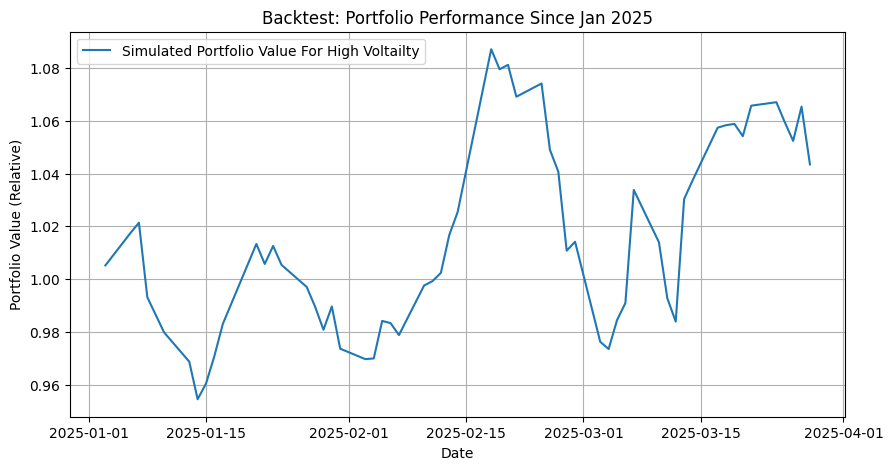

In [17]:
strategy_cutoff = "2025-01-01"
today = datetime.today().strftime("%Y-%m-%d")

high_vol_stocks = get_high_volatility_stocks(
    all_stocks, start_date, strategy_cutoff, top_n=top_n  # or any number you like
)
# Run portfolio selection using data *before* Jan 1, 2025
past_selected, past_weights, _ = get_optimal_portfolio(
    high_vol_stocks, start_date, strategy_cutoff, forecast_horizon=forecast_horizon, num_holdings=num_holdings
)

# Download price data from Jan 1, 2025 to today for backtest
future_prices = yf.download(past_selected, start=strategy_cutoff, end=today, progress=False)["Close"]
future_prices = future_prices.dropna(axis=1, how='all')
returns = future_prices.pct_change().dropna()

# Calculate portfolio value over time
weighted_returns = returns @ past_weights
cumulative_return = (1 + weighted_returns).cumprod()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return, label="Simulated Portfolio Value For High Voltailty")
plt.title("Backtest: Portfolio Performance Since Jan 2025")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Relative)")
plt.grid(True)
plt.legend()
plt.show()


General Backtesting


1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-01-01)')



Optimal Portfolio Allocation:
SMCI: 1.68%
MRNA: 8.12%
CZR: 0.00%
DG: 30.20%
CVS: 0.00%
BIIB: 29.26%
INTC: 14.99%
HUM: 8.98%
ALGN: 5.10%
BLDR: 1.68%


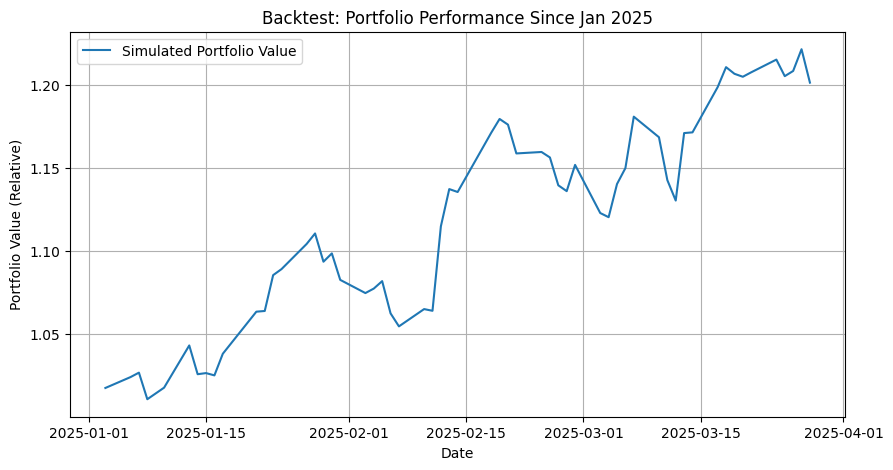

In [18]:
strategy_cutoff = "2025-01-01"
today = datetime.today().strftime("%Y-%m-%d")


# Run portfolio selection using data *before* Jan 1, 2025
past_selected, past_weights, _ = get_optimal_portfolio(
    all_stocks, start_date, strategy_cutoff, forecast_horizon=forecast_horizon, num_holdings=num_holdings
)

# Download price data from Jan 1, 2025 to today for backtest
future_prices = yf.download(past_selected, start=strategy_cutoff, end=today, progress=False)["Close"]
future_prices = future_prices.dropna(axis=1, how='all')
returns = future_prices.pct_change().dropna()

# Calculate portfolio value over time
weighted_returns = returns @ past_weights
cumulative_return = (1 + weighted_returns).cumprod()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return, label="Simulated Portfolio Value")
plt.title("Backtest: Portfolio Performance Since Jan 2025")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Relative)")
plt.grid(True)
plt.legend()
plt.show()
